## Urban Sound Classification using Convolutional Neural Networks with Keras: Theory and Implementation

https://medium.com/gradientcrescent/urban-sound-classification-using-convolutional-neural-networks-with-keras-theory-and-486e92785df4

The UrbanSound dataset consists of 8732 labelled short (less than 4 s) sound excerpts of urban sounds from 10 different classes. Both our training and test datasets consist of .wav files and an accompanying .csv spreadsheet detailing their ID and in the case of the training data, their correct descriptions, which serve as their labels. In order to convert our data into spectrogram representations, we will utilize LibROSA, an open-source python package for music and audio analysis.

UrbanSoundDataset
: https://urbansounddataset.weebly.com/

아래는 다른 Kaggle site에 올려진 데이터. weebly꺼 말고 이걸 받아서 사용함.
```
train.zip (3GB) 
test.zip (2GB)
```
The dataset is called UrbanSound and contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: - The dataset contains 8732 sound excerpts (<=4s) of urban sounds from 10 classes, namely: Air Conditioner Car Horn Children Playing Dog bark Drilling Engine Idling Gun Shot Jackhammer Siren Street Music The attributes of data are as follows: ID – Unique ID of sound excerpt Class – type of sound

https://www.kaggle.com/devilsknight/sound-classification-using-spectrogram-images

Source of the dataset : https://drive.google.com/drive/folders/0By0bAi7hOBAFUHVXd1JCN3MwTEU

Source of research document : https://serv.cusp.nyu.edu/projects/urbansounddataset/salamon_urbansound_acmmm14.pdf


In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(3) # gpu idx

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
dataloc='/home/seung/dataset/UrbanSound_devilsknight'
!ls $dataloc

test  train


In [3]:
from memory_profiler import memory_usage
#https://github.com/giampaolo/psutil/issues/1143#issuecomment-334695523
import os
import pandas as pd
from glob import glob
import numpy as np
#import tqdm as tqdm
from tqdm import tqdm_notebook as tqdm

!apt-get install libav-tools -y

In order to convert our data into spectrogram representations, we will utilize LibROSA, an open-source python package for music and audio analysis.

In [4]:
from keras import layers
from keras import models
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from path import Path

Using TensorFlow backend.


In [5]:
from DDUtil import *

In [6]:
n_classes = 1
bCreateFile=False#False
base_dir_out = '/home/seung/data/out-audio1/'
outDir = '{}/n21_CL{}'.format(base_dir_out, n_classes)
MakeDir(outDir)
MakeDir(base_dir_out+'_train')
MakeDir(base_dir_out+'_test')

print('Created {}'.format(outDir))

Created /home/seung/data/out-audio1//n21_CL1


In [7]:
!ls /home/seung/data/out-audio1

n21_CL1  n21_CL1model.h5  _test  _train


~/.venv/py3Keras/bin/pip install -I path.py==7.7.1

In [8]:
def create_spectrogram(outdir, filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    fout  = outdir + '/_train/' + name + '.jpg'
    plt.savefig(fout, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del fout,name,clip,sample_rate,fig,ax,S

In [9]:
def create_spectrogram_test(outdir, filename, name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    #fout  = Path(outdir +'/test/' + name + '.jpg')
    fout  = outdir +'/_test/' + name + '.jpg'
    fig.savefig(fout, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del fout,name,clip,sample_rate,fig,ax,S

In [10]:
Data_dir=np.array(glob(dataloc+'/train/Train/*'))
Test_dir=np.array(glob(dataloc+'/test/Test/*'))
print('Train : {}'.format(Data_dir.shape))
print('Test : {}'.format(Test_dir.shape))

Train : (5435,)
Test : (3297,)


In [11]:
Data_dir[:3]

array(['/home/seung/dataset/UrbanSound_devilsknight/train/Train/7893.wav',
       '/home/seung/dataset/UrbanSound_devilsknight/train/Train/5178.wav',
       '/home/seung/dataset/UrbanSound_devilsknight/train/Train/495.wav'],
      dtype='<U64')

In [12]:
%load_ext memory_profiler
%memit
i=0
if bCreateFile:
    with tqdm(total=len(Data_dir[i:i+2000])) as pbar:
        for file in Data_dir[i:i+2000]:
            filename,name = file,file.split('/')[-1].split('.')[0]
            create_spectrogram(base_dir_out,filename,name)
            pbar.update(1)
    gc.collect()

peak memory: 373.33 MiB, increment: 0.01 MiB


In [13]:
len(Data_dir[i:i+2000])

2000

In [14]:
%memit 
i=2000
if bCreateFile:
    with tqdm(total=len(Data_dir[i:i+2000])) as pbar:
        for file in Data_dir[i:i+2000]:
            filename,name = file,file.split('/')[-1].split('.')[0]
            create_spectrogram(base_dir_out,filename,name)
            pbar.update(1)
    gc.collect()

peak memory: 373.34 MiB, increment: 0.00 MiB


In [15]:
%memit 
i=4000
if bCreateFile:
    with tqdm(total=len(Data_dir[i:])) as pbar:
        for file in Data_dir[i:]:
            filename,name = file,file.split('/')[-1].split('.')[0]
            create_spectrogram(base_dir_out,filename,name)
            pbar.update(1)
    gc.collect()

peak memory: 373.35 MiB, increment: 0.00 MiB


Doing the same for our test dataset:

In [16]:
%memit
i=0
if bCreateFile:
    with tqdm(total=len(Test_dir[i:i+2000])) as pbar:
        for file in Test_dir[i:i+2000]:
            filename,name = file,file.split('/')[-1].split('.')[0]
            create_spectrogram_test(base_dir_out,filename,name)
            pbar.update(1)
    gc.collect()

peak memory: 373.35 MiB, increment: 0.00 MiB


In [17]:
%memit
i=2000
if bCreateFile:
    with tqdm(total=len(Test_dir[i:])) as pbar:
        for file in Test_dir[i:]:
            filename,name = file,file.split('/')[-1].split('.')[0]
            create_spectrogram_test(base_dir_out,filename,name)
            pbar.update(1)
    gc.collect()

peak memory: 373.43 MiB, increment: 0.00 MiB


In [18]:
from keras.preprocessing.image import ImageDataGenerator

def append_ext(fn):
    return fn+".jpg"

In [19]:
dataloc_test=dataloc+'/test'
dataloc_train=dataloc+'/train'

!ls $dataloc_test

Test  test.csv


In [20]:
csv_train = dataloc_train+'/train.csv'
csv_test = dataloc_test+'/test.csv'
print(csv_train)
print(csv_test)

/home/seung/dataset/UrbanSound_devilsknight/train/train.csv
/home/seung/dataset/UrbanSound_devilsknight/test/test.csv


In [21]:
traindf=pd.read_csv(csv_train,dtype=str)
testdf=pd.read_csv(csv_test,dtype=str)
traindf["ID"]=traindf["ID"].apply(append_ext)
testdf["ID"]=testdf["ID"].apply(append_ext)

In [22]:
traindf.head

<bound method NDFrame.head of             ID            Class
0        0.jpg            siren
1        1.jpg     street_music
2        2.jpg         drilling
3        3.jpg            siren
4        4.jpg         dog_bark
...        ...              ...
5430  8725.jpg    engine_idling
5431  8726.jpg         dog_bark
5432  8727.jpg    engine_idling
5433  8728.jpg    engine_idling
5434  8729.jpg  air_conditioner

[5435 rows x 2 columns]>

In [23]:
traindf["ID"]

0          0.jpg
1          1.jpg
2          2.jpg
3          3.jpg
4          4.jpg
          ...   
5430    8725.jpg
5431    8726.jpg
5432    8727.jpg
5433    8728.jpg
5434    8729.jpg
Name: ID, Length: 5435, dtype: object

In [24]:
import keras
print(keras.__version__)

2.2.5


In [25]:
#datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)
#datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
#datagen = ImageDataGenerator(rescale=1./255)
#datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
#datagen=ImageDataGenerator(rescale=1./255.) # keras 2.1.2
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [26]:
train_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=base_dir_out+'_train',
    x_col="ID",
    y_col="Class",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

Found 4077 validated image filenames belonging to 10 classes.


In [27]:
valid_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=base_dir_out+'_train',#directory="/kaggle/working/train/",
    x_col="ID",
    y_col="Class",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

Found 1358 validated image filenames belonging to 10 classes.


In [28]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

In [40]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',  input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 31, 31, 64)       

In [30]:
#Fitting keras model, no test gen for now
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print('STEP_SIZE_TRAIN={}'.format(STEP_SIZE_TRAIN))
print('STEP_SIZE_VALID={}'.format(STEP_SIZE_VALID))

STEP_SIZE_TRAIN=127
STEP_SIZE_VALID=42


In [31]:
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
hist = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=300
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
127/127 [==============================] - 7s 58ms/step - loss: 2.0673 - acc: 0.2194 - val_loss: 1.8548 - val_acc: 0.3274
Epoch 2/10
127/127 [==============================] - 5s 42ms/step - loss: 1.7706 - acc: 0.3558 - val_loss: 1.4563 - val_acc: 0.4932
Epoch 3/10
127/127 [==============================] - 5s 41ms/step - loss: 1.4045 - acc: 0.5144 - val_loss: 1.2433 - val_acc: 0.5950
Epoch 4/10
127/127 [==============================] - 5s 41ms/step - loss: 1.1255 - acc: 0.6237 - val_loss: 0.8869 - val_acc: 0.6991
Epoch 5/10
127/127 [==============================] - 5s 41ms/step - loss: 0.9299 - acc: 0.6890 - val_loss: 0.8441 - val_acc: 0.7285
Epoch 6/10
127/127 [==============================] - 5s 41ms/step - loss: 0.8115 - acc: 0.7215 - val_loss: 0.7138 - val_acc: 0.7700
Epoch 7/10
127/127 [==============================] - 5s 40ms/step - loss: 0.7037 - acc: 0.7665 - val_loss: 0.7496 - val_acc: 0.7624
Epoch 8/10
127/127 [=

In [32]:
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

[0.570209165768964, 0.8139880952380952]

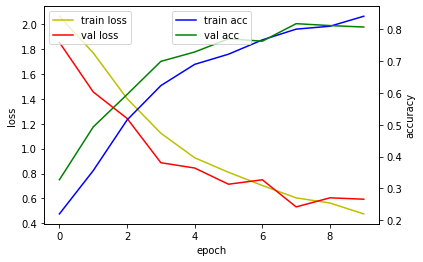

In [39]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper center')


In [34]:
fnmodel=outDir+'model.h5'
print(fnmodel)
model.save(fnmodel)

/home/seung/data/out-audio1//n21_CL1model.h5
